In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py

from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pqw

from functools import reduce
import operator
import gc

h = 0.6774
box_size = 205000

In [2]:
# plot settings
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [3]:
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.functions import broadcast, col, sqrt, pow, floor, monotonically_increasing_id, abs, pmod, least, row_number
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

spark = SparkSession.builder \
    .appName("MyApp") \
    .master("spark://sohnic:7077") \
    .config("spark.executor.memory", "100g")\
    .config("spark.driver.memory", "100g") \
    .getOrCreate()

sc = spark.sparkContext
sc.setCheckpointDir("hdfs://sohnic:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize", 524288000) # 500MB 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/01 12:26:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. Reading the particle and subhalo data

In [6]:
%%time
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_sorted.parquet.snappy'
outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_cubic_indexed.parquet.snappy'

rawdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(outname)

CPU times: user 2.68 ms, sys: 1.9 ms, total: 4.58 ms
Wall time: 475 ms


In [7]:
##dividing the data into 100*100*100 boxes and adding the column for the box id
#rawdf = rawdf.withColumn("ix", floor(F.col("px") / (box_size/100) ).cast('int'))
#rawdf = rawdf.withColumn("iy", floor(F.col("py") / (box_size/100) ).cast('int'))
#rawdf = rawdf.withColumn("iz", floor(F.col("pz") / (box_size/100) ).cast('int'))
#
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_cubic_indexed.parquet.snappy'
#rawdf.write.option("compression", "snappy").mode("overwrite").save(outname)

In [8]:
rawdf.printSchema()

root
 |-- px: double (nullable = true)
 |-- py: double (nullable = true)
 |-- pz: double (nullable = true)
 |-- vx: double (nullable = true)
 |-- vy: double (nullable = true)
 |-- vz: double (nullable = true)
 |-- mass: double (nullable = true)
 |-- ix: integer (nullable = true)
 |-- iy: integer (nullable = true)
 |-- iz: integer (nullable = true)



In [9]:
%%time
rawdf.limit(4).toPandas().T

CPU times: user 33.4 ms, sys: 6.2 ms, total: 39.6 ms
Wall time: 7.4 s


,0,1,2,3
px,91627.086451,91631.104039,91624.890629,91630.127959
py,77359.627285,77365.758346,77361.689091,77358.576125
pz,50717.781615,50718.788901,50715.777671,50713.826579
vx,-468.145940,-403.373400,-468.546050,-472.101960
vy,197.275180,126.342120,275.190600,208.752870
vz,-181.936140,-209.147260,-106.415016,-132.136810
mass,0.000753,0.000461,0.000608,0.000715
ix,44.000000,44.000000,44.000000,44.000000
iy,37.000000,37.000000,37.000000,37.000000
iz,24.000000,24.000000,24.000000,24.000000


In [7]:
%%time
rawdf.describe().show() 

+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+-----------------+------------------+------------------+
|summary|                px|               py|                pz|                vx|                vy|                  vz|                mass|               ix|                iy|                iz|
+-------+------------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+-----------------+------------------+------------------+
|  count|         711967480|        711967480|         711967480|         711967480|         711967480|           711967480|           711967480|        711967480|         711967480|         711967480|
|   mean|100688.61828005519|99059.36895091036|105857.77590178403|1.2704478306707212|1.0880226031171873|-0.30910798969780456|5.280344892323583E-4|48.61480849659032|47.819169449986674| 51.138042

In [40]:
%%time
#subhalo table
#subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_trim.parquet.snappy'
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_trim_cubic_indexed.parquet.snappy'
subdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(subname)

subdf.limit(4).toPandas()
#subdf.describe().toPandas().T 

CPU times: user 5.2 ms, sys: 8.61 ms, total: 13.8 ms
Wall time: 353 ms


,sub_px,sub_py,sub_pz,sub_vx,sub_vy,sub_vz,sub_mass,sub_id,sub_ix,sub_iy,sub_iz
0,58355.187500,92089.484375,12080.269531,-21.297447,-188.723267,-141.249176,3.658641e+10,72219,28,44,5
1,69247.859375,153347.531250,58367.277344,-275.569366,116.315620,-9.869348,3.546034e+10,72220,33,74,28
2,201050.093750,99407.570312,131901.484375,340.077118,30.196972,348.744080,3.377322e+10,72221,98,48,64
3,187448.234375,99925.515625,199232.187500,-120.749687,508.878906,-329.542816,3.269676e+10,72222,91,48,97


# 2. Saving the particle data within the 3*3*3 nearby subboxes centered at each subhalo

In [10]:
def periodic_boundary(val, max_val):
    return (val + max_val) % max_val

periodic_udf = F.udf(lambda val: periodic_boundary(val, 100), T.IntegerType())

nearby_indices = subdf.select(
    'sub_id',
    periodic_udf(F.col('sub_ix') - 1).alias('sub_ix_min'),  
    F.col('sub_ix').alias('sub_ix'),            
    periodic_udf(F.col('sub_ix') + 1).alias('sub_ix_max'),  
    
    periodic_udf(F.col('sub_iy') - 1).alias('sub_iy_min'),  
    F.col('sub_iy').alias('sub_iy'),            
    periodic_udf(F.col('sub_iy') + 1).alias('sub_iy_max'),  
    
    periodic_udf(F.col('sub_iz') - 1).alias('sub_iz_min'),  
    F.col('sub_iz').alias('sub_iz'),            
    periodic_udf(F.col('sub_iz') + 1).alias('sub_iz_max')
)

nearby_indices.show()

+------+----------+------+----------+----------+------+----------+----------+------+----------+
|sub_id|sub_ix_min|sub_ix|sub_ix_max|sub_iy_min|sub_iy|sub_iy_max|sub_iz_min|sub_iz|sub_iz_max|
+------+----------+------+----------+----------+------+----------+----------+------+----------+
|103713|        47|    48|        49|        18|    19|        20|        51|    52|        53|
|103714|        57|    58|        59|        33|    34|        35|        76|    77|        78|
|103715|        98|    99|         0|        82|    83|        84|        41|    42|        43|
|103716|        83|    84|        85|        76|    77|        78|        78|    79|        80|
|103717|        15|    16|        17|        16|    17|        18|        71|    72|        73|
|103718|        19|    20|        21|        74|    75|        76|        51|    52|        53|
|103719|        85|    86|        87|        53|    54|        55|         3|     4|         5|
|103720|        54|    55|        56|   

In [11]:
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_nearby_indices_241030.parquet.snappy'
nearby_indices.write.option("compression", "snappy").mode("overwrite").parquet(subname)

In [8]:
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_nearby_indices_241030.parquet.snappy'
nearby_indices = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(subname)

In [11]:
nearby_subboxes = nearby_indices.select(
    'sub_id',
    F.array('sub_ix_min', 'sub_ix', 'sub_ix_max').alias('ix_values'),
    F.array('sub_iy_min', 'sub_iy', 'sub_iy_max').alias('iy_values'),
    F.array('sub_iz_min', 'sub_iz', 'sub_iz_max').alias('iz_values')
)

# Broadcast the nearby indices
broadcast_indices = spark.sparkContext.broadcast(nearby_subboxes.collect())
broadcast_df = spark.createDataFrame(broadcast_indices.value)

# Join using array_contains
filtered_particles = (
    rawdf.alias("particles")
    .join(
        broadcast_df.alias("indices"),
        (F.expr("array_contains(ix_values, particles.ix)") &
         F.expr("array_contains(iy_values, particles.iy)") &
         F.expr("array_contains(iz_values, particles.iz)"))
    )
    .select("indices.sub_id", "particles.*")
)

# Write the filtered particles partitioned by `sub_id`
filtered_particles.write.partitionBy("sub_id").mode("overwrite").parquet("hdfs://sohnic:54310/data/TNG300/snap99/parquet/filtered_particles_all_subhalos.parquet.snappy")

In [5]:
#Checking the data
subname = "hdfs://sohnic:54310/data/TNG300/snap99/parquet/filtered_particles_all_subhalos.parquet.snappy"
df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 72219)
df_filtered.describe().toPandas()

,summary,px,py,pz,vx,vy,vz,mass,ix,iy,iz,sub_id
0,count,215100,215100,215100,215100,215100,215100,215100,215100,215100,215100,215100
1,mean,57133.644093612005,90649.7194356092,11123.164640781797,-210.3525775939913,66.27039211479483,-187.15265791627368,5.255117774213014E-4,27.574848907484892,43.59951650395165,5.03278010227801,72219.0
2,stddev,1729.5584140744315,1809.4549615033577,1256.0918178481097,274.0788000160852,373.30040202137405,294.79204279023094,1.409379277640708E-4,0.8545463583465241,0.8759228830545569,0.4438120676689592,0.0
3,min,55350.121781023925,88232.58822948304,8241.297460548994,-1621.3925,-1502.6763,-1760.0502,4.1590643E-5,27,43,4,72219
4,max,61384.57354325517,94297.74851770078,14349.642482493326,1412.1672,1726.897,1280.9865,0.0012715535,29,45,6,72219


In [44]:
%%time
#counting the number of particles in each 3*3*3 subboxes
counts_df = df.groupBy("sub_id").agg(F.count("*").alias("particle_count"))

# Collect the results into pandas DataFrame for plotting
pandas_counts_df = counts_df.toPandas()

CPU times: user 4.58 s, sys: 647 ms, total: 5.23 s
Wall time: 20min 7s


In [45]:
pandas_counts_df.head()

,sub_id,particle_count
0,96415,606589
1,62680,361526
2,6658,352787
3,50353,352787
4,6397,906923


In [46]:
print(np.average(pandas_counts_df['particle_count']))

122568.92724078853


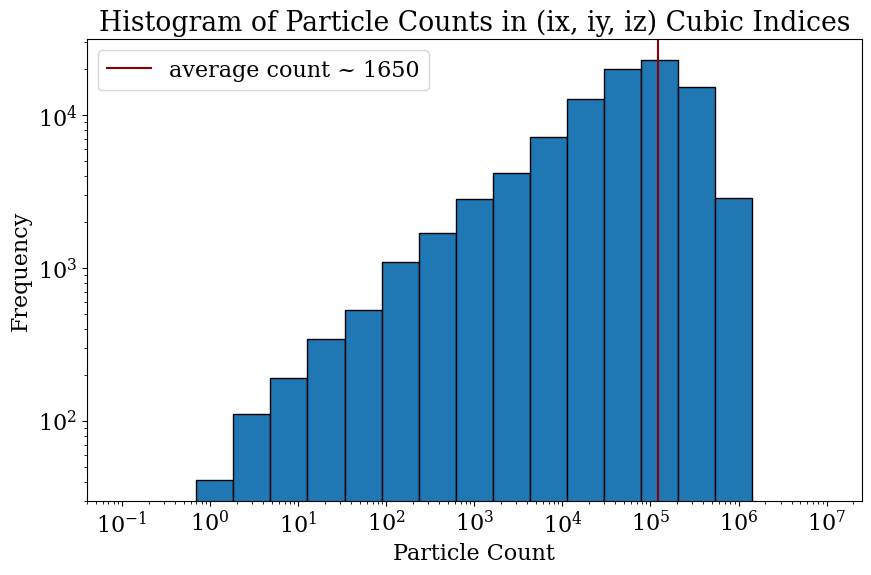

In [47]:
plt.figure(figsize=(10,6))
plt.hist(pandas_counts_df['particle_count'], bins=np.logspace(-1, 7, 20), edgecolor='black')
plt.axvline(x=np.average(pandas_counts_df['particle_count']), color = 'darkred',label = 'average count ~ 1650')
plt.title("Histogram of Particle Counts in (ix, iy, iz) Cubic Indices")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Particle Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 2-1. KDTree Algorithm

In [30]:
#unique subbox id pairs
# Step 1: Select the relevant columns and get distinct values
unique_ids_df = subdf.select("sub_ix", "sub_iy", "sub_iz").distinct()

# Step 2: Collect the results to get a list of unique (id_x, id_y, id_z) tuples
unique_ids_list = unique_ids_df.rdd.map(tuple).collect()
print(len(unique_ids_list))

39161


In [42]:
%%time
#kd-tree algorithm

radius_kpc = 50 * h  # 50 kpc aperture size
id_size = 100 # number of boxes

#for the subbox id pair (ix, iy, iz)
id_pair = unique_ids_list[0]
subbox_size = box_size / id_size

#center position of the subbox
box_cent = np.array(id_pair) * subbox_size + np.array([1,1,1]) * subbox_size/2

#rough filtering using subbox id
filtered_ptl_df = rawdf.filter(
    (F.least(F.abs(F.col("ix") - id_pair[0]), id_size - F.abs(F.col("ix") - id_pair[0]) ) <= 1) &
    (F.least(F.abs(F.col("iy") - id_pair[1]), id_size - F.abs(F.col("iy") - id_pair[1]) ) <= 1) &
    (F.least(F.abs(F.col("iz") - id_pair[2]), id_size - F.abs(F.col("iz") - id_pair[2]) ) <= 1))

filtered_sub_df = subdf.filter(
    (F.least(F.abs(F.col("sub_ix") - id_pair[0]), id_size - F.abs(F.col("sub_ix") - id_pair[0]) ) <= 1) &
    (F.least(F.abs(F.col("sub_iy") - id_pair[1]), id_size - F.abs(F.col("sub_iy") - id_pair[1]) ) <= 1) &
    (F.least(F.abs(F.col("sub_iz") - id_pair[2]), id_size - F.abs(F.col("sub_iz") - id_pair[2]) ) <= 1))

#relative coordinate from the subbox center (box_cent). Considering the periodic boundary
filtered_ptl_df = filtered_ptl_df.withColumn(
    "px_box_cent",
    F.pmod((F.col("px") - box_cent[0]) + box_size / 2, box_size) - box_size / 2
).withColumn(
    "py_box_cent",
    F.pmod((F.col("py") - box_cent[1]) + box_size / 2, box_size) - box_size / 2
).withColumn(
    "pz_box_cent",
    F.pmod((F.col("pz") - box_cent[2]) + box_size / 2, box_size) - box_size / 2
)

filtered_sub_df = filtered_sub_df.withColumn(
    "sub_px_box_cent",
    F.pmod((F.col("sub_px") - box_cent[0]) + box_size / 2, box_size) - box_size / 2
).withColumn(
    "sub_py_box_cent",
    F.pmod((F.col("sub_py") - box_cent[1]) + box_size / 2, box_size) - box_size / 2
).withColumn(
    "sub_pz_box_cent",
    F.pmod((F.col("sub_pz") - box_cent[2]) + box_size / 2, box_size) - box_size / 2
)

# Step 1: Convert PySpark DataFrames to Pandas
particle_df_pd = filtered_ptl_df.select("px", "py", "pz", "vx", "vy", "vz", "mass", "px_box_cent", "py_box_cent", "pz_box_cent").toPandas()
subhalo_df_pd = filtered_sub_df.select("sub_id", "sub_px_box_cent", "sub_py_box_cent", "sub_pz_box_cent").toPandas()

# Step 2: Build cKDTree with Particle Positions
particle_positions = particle_df_pd[["px_box_cent", "py_box_cent", "pz_box_cent"]].values
ckdtree = cKDTree(particle_positions)  # Use cKDTree

subhalo_positions = subhalo_df_pd[["sub_px_box_cent", "sub_py_box_cent", "sub_pz_box_cent"]].values
indices = ckdtree.query_ball_point(subhalo_positions, r=radius_kpc)

#saving the relevant data
filtered_particles = []
for sub_idx, particle_idx_list in enumerate(indices):
    if particle_idx_list:
        # For each subhalo, find the corresponding particles and save relevant data
        subhalo = subhalo_df_pd.iloc[sub_idx]
        subhalo_pos = subhalo[["sub_px_box_cent", "sub_py_box_cent", "sub_pz_box_cent"]].values
        
        for particle_idx in particle_idx_list:
            particle = particle_df_pd.iloc[particle_idx]
            particle_pos = particle[["px_box_cent", "py_box_cent", "pz_box_cent"]].values
            
            # Calculate squared distance (dist_cent_sq) between particle and subhalo
            dist_cent_sq = np.sum((particle_pos - subhalo_pos) ** 2)
            
            # Save the particle and subhalo data along with the squared distance
            filtered_particles.append({
                'sub_id': subhalo['sub_id'],
                'px': particle['px'],
                'py': particle['py'],
                'pz': particle['pz'],
                'vx': particle['vx'],
                'vy': particle['vy'],
                'vz': particle['vz'],
                'mass': particle['mass'],
                'dist_cent_sq': dist_cent_sq  # Include the squared distance
            })

# Step 5: Convert filtered particles to Pandas DataFrame and back to PySpark
filtered_df_pd = pd.DataFrame(filtered_particles)
filtered_df = spark.createDataFrame(filtered_df_pd)

# Step 6: Save the results with partitioning by sub_id
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_241002_kdtree_particles.parquet.snappy'
filtered_df.write.option("compression", "snappy").mode("overwrite").partitionBy("sub_id").parquet(subname)

/usr/local/spark/python/pyspark/sql/pandas/serializers.py:229: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(s.dtype):


CPU times: user 23.9 s, sys: 452 ms, total: 24.4 s
Wall time: 1min 6s


In [7]:
#Checking the data
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'
df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 10000)
df_filtered.describe().toPandas()

,summary,px,py,pz,vx,vy,vz,mass,dist_cent_sq,sub_id
0,count,160,160,160,160,160,160,160,160,160
1,mean,86539.98217092815,115001.8123021865,144899.63376864442,-173.17213001875004,-162.7695493062501,201.53382877500002,5.594609641875001E-4,52.507032744363826,10000.0
2,stddev,4.3586223280873195,3.330779277000689,4.676035647780895,39.405089898886125,39.32917348856376,38.71986463333312,1.4510780084495814E-4,133.96340006846228,0.0
3,min,86517.54089495828,114987.06916561146,144874.48056289784,-298.88245,-250.64078,100.80679,2.5858832E-4,0.3857580077748698,10000
4,max,86558.38979516154,115009.8895705654,144911.07695180256,-54.3939,-47.9957,280.2506,8.7464123E-4,1050.5479423833408,10000


# 3. Calculating stellar velocity dispersion

We measure the stellar velocity dispersion of ~10$^5$ subhalos. We first select stellar particles within subhalo-centered spheres with a certain radius. We then calculate the mass-weighted stellar velocity dispersion based on the 3D velocity of selected stellar particles. 

### $M = \Sigma m_i $
### $\overline{v_x} = \frac{\Sigma m_i v_{i,x}}{M}$, $\, \overline{v_y} = \frac{\Sigma m_i v_{i,y}}{M}$, $\, \overline{v_z} = \frac{\Sigma m_i v_{i,z}}{M}$ 
### $\sigma_x^2 = \frac{\Sigma m_i (v_{i,x} - \overline{v_{x}})^2}{M}$, $\, \sigma_y^2 = \frac{\Sigma m_i (v_{i,y} - \overline{v_{y}})^2}{M}$, $\, \sigma_z^2 = \frac{\Sigma m_i (v_{i,z} - \overline{v_{z}})^2}{M}$
### $\therefore \sigma_{3D} = \sqrt{\sigma_x^2 + \sigma_y^2 + \sigma_z^2}$
We repeat the above calculation for six different radii (3, 5, 10, 20, 30, and 50 kpc).

In [15]:
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'

df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 0)
df_filtered.describe().toPandas()

,summary,px,py,pz,vx,vy,vz,mass,dist_cent_sq,sub_id
0,count,140,140,140,140,140,140,140,140,140
1,mean,41840.652056403436,49050.240491958146,146618.59384127078,491.1804762142857,2141.1263542857128,-734.4352684999993,5.289361012142856E-4,33.778025427646135,0.0
2,stddev,3.434179745897391,2.646253888959987,3.8308437191442546,47.42457028605087,43.16277394559926,46.21973330251511,1.3347494347952017E-4,69.45086123003283,0.0
3,min,41821.05056670708,49042.46942823968,146605.40289966715,330.69318,2015.9958,-865.76483,2.9745823E-4,2.034020586918334E-7,0
4,max,41854.11205584526,49061.58165936835,146634.89777236278,636.5443,2252.1292,-622.19794,8.7916595E-4,445.53822808873207,0


In [16]:
subhalo_count = df.select("sub_id").distinct().count()
print(f"Number of distinct subhalo IDs: {subhalo_count}")

Number of distinct subhalo IDs: 104290


In [17]:
%%time
from pyspark.sql import Window as W
import pyspark.sql.functions as F

# Define subhalo window for partitioning by "sub_id"
subhalo_window = W.partitionBy("sub_id")

# Initial weighted velocity and dispersion calculations for all particles
df = df.withColumn("vx_weighted", F.col("mass") * F.col("vx"))
df = df.withColumn("vy_weighted", F.col("mass") * F.col("vy"))
df = df.withColumn("vz_weighted", F.col("mass") * F.col("vz"))

df = df.withColumn("mass_sum", F.sum("mass").over(subhalo_window))

df = df.withColumn("vx_avg", F.sum("vx_weighted").over(subhalo_window) / F.col("mass_sum"))
df = df.withColumn("vy_avg", F.sum("vy_weighted").over(subhalo_window) / F.col("mass_sum"))
df = df.withColumn("vz_avg", F.sum("vz_weighted").over(subhalo_window) / F.col("mass_sum"))

df = df.withColumn("vx_disp", (F.col("vx") - F.col("vx_avg"))**2)
df = df.withColumn("vy_disp", (F.col("vy") - F.col("vy_avg"))**2)
df = df.withColumn("vz_disp", (F.col("vz") - F.col("vz_avg"))**2)

df = df.withColumn("dispersion_weighted", F.col("mass") * (F.col("vx_disp") + F.col("vy_disp") + F.col("vz_disp")))

# First aperture (50 kpc)
velocity_dispersion_df = df.groupBy("sub_id").agg(
    (F.sqrt(F.sum("dispersion_weighted") / F.sum("mass"))).alias("mass_weighted_velocity_dispersion_50")
)

# Iterate through different apertures (30, 20, 10, 5, 3 kpc)
for apert in [30, 20, 10, 5, 3]:
    # Reset the DataFrame for each aperture
    distance_limit = (apert * h) ** 2
    df_aperture = df.filter(F.col("dist_cent_sq") <= distance_limit)

    df_aperture = df_aperture.withColumn("mass_sum", F.sum("mass").over(subhalo_window))
    
    df_aperture = df_aperture.withColumn("vx_avg", F.sum("vx_weighted").over(subhalo_window) / F.col("mass_sum"))
    df_aperture = df_aperture.withColumn("vy_avg", F.sum("vy_weighted").over(subhalo_window) / F.col("mass_sum"))
    df_aperture = df_aperture.withColumn("vz_avg", F.sum("vz_weighted").over(subhalo_window) / F.col("mass_sum"))
    
    df_aperture = df_aperture.withColumn("vx_disp", (F.col("vx") - F.col("vx_avg"))**2)
    df_aperture = df_aperture.withColumn("vy_disp", (F.col("vy") - F.col("vy_avg"))**2)
    df_aperture = df_aperture.withColumn("vz_disp", (F.col("vz") - F.col("vz_avg"))**2)
    
    df_aperture = df_aperture.withColumn("dispersion_weighted", F.col("mass") * (F.col("vx_disp") + F.col("vy_disp") + F.col("vz_disp")))

    velocity_dispersion_tmp = df_aperture.groupBy("sub_id").agg(
        (F.sqrt(F.sum("dispersion_weighted") / F.sum("mass"))).alias("mass_weighted_velocity_dispersion_" + str(apert))
    )
    
    # Combine the results for each aperture
    velocity_dispersion_df = velocity_dispersion_df.join(velocity_dispersion_tmp, "sub_id")

# Show the final combined DataFrame
velocity_dispersion_df.show()

+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|sub_id|mass_weighted_velocity_dispersion_50|mass_weighted_velocity_dispersion_30|mass_weighted_velocity_dispersion_20|mass_weighted_velocity_dispersion_10|mass_weighted_velocity_dispersion_5|mass_weighted_velocity_dispersion_3|
+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|   148|                  60.353250511042376|                   61.38776748254439|                   62.38146856184683|                   65.64963521122424|                  70.08732553224417|                  68.72902382988421|
|   463|                  350.06665387531825|                  174.37952255146064|  

In [18]:
sub_id_to_find = 10000
filtered_df = velocity_dispersion_df.filter(velocity_dispersion_df["sub_id"] == sub_id_to_find)
filtered_df.show()

+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|sub_id|mass_weighted_velocity_dispersion_50|mass_weighted_velocity_dispersion_30|mass_weighted_velocity_dispersion_20|mass_weighted_velocity_dispersion_10|mass_weighted_velocity_dispersion_5|mass_weighted_velocity_dispersion_3|
+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
| 10000|                   67.54407056722899|                   67.25768361639068|                   67.79019897412951|                   68.88366311763865|                  72.93970174994601|                  73.40487757132327|
+------+------------------------------------+------------------------------------+--

In [19]:
parquet_files_path = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/vdisp_241015/vdisp_241015.parquet'
velocity_dispersion_df.write.option("compression", "snappy").mode("overwrite").parquet(parquet_files_path)

# 1-1 Comparison

In [28]:
parquet_files_path = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/vdisp_241015/vdisp_241015.parquet'
df = spark.read.parquet(parquet_files_path)

In [29]:
subhalo_count = df.select("sub_id").distinct().count()
print(subhalo_count)

104288


In [30]:
#subhalo table (~few seconds)
t300 = pd.read_csv('./TNG300_quiescent_subhalos.csv')
print(len(t300))
t300.head()

104290


,Unnamed: 0,ID,GrNr,Posx,Posy,Posz,CMx,CMy,CMz,Velx,...,vdisp_dm_pos_sph_rh_z_bi,vdisp_dm_pos_sph_rh_z_mweight,vdisp_dm_pos_sph_rh_z_lweight,vdisp_dm_pos_sph_rh_3d_std,vdisp_dm_pos_sph_rh_3d_bi,vdisp_dm_pos_sph_rh_3d_mweight,vdisp_dm_pos_sph_rh_3d_lweight,central,quiescent,edge
0,1,394,0,41839.938,49050.410,146618.52,41841.720,49049.500,146618.42,505.39545,...,56.230135,0.0,0.0,93.595999,94.790011,0.0,0.0,0,1,1
1,2,403,0,45247.900,51453.363,145176.55,45247.434,51453.367,145176.25,484.58800,...,61.195377,0.0,0.0,108.910434,110.497556,0.0,0.0,0,1,1
2,3,421,0,43345.830,50114.844,148136.55,43344.582,50116.066,148136.56,2266.76460,...,57.704420,0.0,0.0,100.625152,102.887322,0.0,0.0,0,1,1
3,4,423,0,43848.816,51581.773,145344.84,43851.332,51581.540,145348.30,-1288.37480,...,49.692601,0.0,0.0,90.353464,92.019996,0.0,0.0,0,1,1
4,5,447,0,44503.348,47543.660,146977.92,44503.926,47543.100,146978.66,-157.55678,...,57.704970,0.0,0.0,102.185058,104.080819,0.0,0.0,0,1,1


In [7]:
a = list(t300.keys())
print(a)

['Unnamed: 0', 'ID', 'GrNr', 'Posx', 'Posy', 'Posz', 'CMx', 'CMy', 'CMz', 'Velx', 'Vely', 'Velz', 'SFR', 'Vmax', 'VelDisp', 'Rh_total', 'Rh_dm', 'Rh_star', 'Mass_total', 'Mass_dm', 'Mass_star', 'vdisp_star_pos_total_x_std', 'vdisp_star_pos_total_x_bi', 'vdisp_star_pos_total_x_mweight', 'vdisp_star_pos_total_x_lweight', 'vdisp_star_pos_total_y_std', 'vdisp_star_pos_total_y_bi', 'vdisp_star_pos_total_y_mweight', 'vdisp_star_pos_total_y_lweight', 'vdisp_star_pos_total_z_std', 'vdisp_star_pos_total_z_bi', 'vdisp_star_pos_total_z_mweight', 'vdisp_star_pos_total_z_lweight', 'vdisp_star_pos_total_3d_std', 'vdisp_star_pos_total_3d_bi', 'vdisp_star_pos_total_3d_mweight', 'vdisp_star_pos_total_3d_lweight', 'vdisp_dm_pos_total_x_std', 'vdisp_dm_pos_total_x_bi', 'vdisp_dm_pos_total_x_mweight', 'vdisp_dm_pos_total_x_lweight', 'vdisp_dm_pos_total_y_std', 'vdisp_dm_pos_total_y_bi', 'vdisp_dm_pos_total_y_mweight', 'vdisp_dm_pos_total_y_lweight', 'vdisp_dm_pos_total_z_std', 'vdisp_dm_pos_total_z_bi', '

In [31]:
sorted_combined_df = df.orderBy('sub_id')
sorted_combined_df.cache()

df_spark = pd.DataFrame()
df_spark['sig'] = sorted_combined_df.select('mass_weighted_velocity_dispersion_20').toPandas()
df_spark['sub_id'] = sorted_combined_df.select('sub_id').toPandas()

In [32]:
df_spark.head()

,sig,sub_id
0,78.503648,0
1,84.243080,1
2,71.280743,2
3,65.791355,3
4,80.627808,4


In [33]:
df_csv = pd.DataFrame()
df_csv['sig_sohn'] = t300['vdisp_star_pos_sph_20kpc_3d_mweight']
df_csv['sub_id'] = range(104290)
df_csv.head(10)

,sig_sohn,sub_id
0,78.503645,0
1,84.243082,1
2,71.280738,2
3,65.791358,3
4,80.627809,4
5,81.150709,5
6,74.807477,6
7,80.576113,7
8,86.694709,8
9,87.394604,9


In [34]:
df_spark[df_spark['sub_id'] == 5] #??

,sig,sub_id
5,81.15071,5


In [35]:
result_df = pd.merge(df_spark, df_csv, on="sub_id", how="inner", suffixes=('_spark', '_csv'))

In [36]:
result_df.tail(30)

,sig,sub_id,sig_sohn
104258,731.702281,104260,731.702280
104259,503.788062,104261,503.788062
104260,554.193008,104262,554.193009
104261,648.526063,104263,611.319688
104262,493.187973,104264,493.187974
104263,600.339510,104265,599.506611
104264,651.781444,104266,651.781443
104265,563.421120,104267,563.421124
104266,569.513012,104268,549.226790
104267,571.805877,104269,571.805872


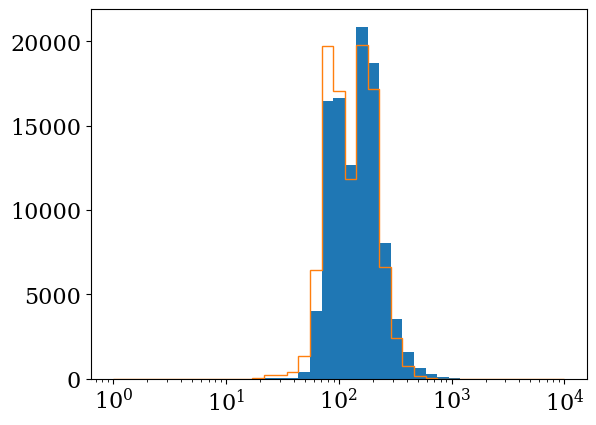

In [37]:
bins = np.logspace(0, 4, 40)
plt.hist(result_df['sig'], bins = bins)
plt.hist(result_df['sig_sohn'], bins = bins, histtype = 'step')
plt.xscale('log')

In [38]:
residuals = result_df['sig_sohn'] - result_df['sig']

# Calculate standard deviation (sigma) of residuals
sigma = np.std(residuals)

# Find the points that deviate more than 1 sigma
#outliers = np.abs(residuals) > sigma
outliers = np.abs(residuals) > 50

# Count the number of outliers
num_outliers = np.sum(outliers)
print(len(residuals))
print(num_outliers)
print(num_outliers / len(residuals))

104288
7739
0.07420796256520405


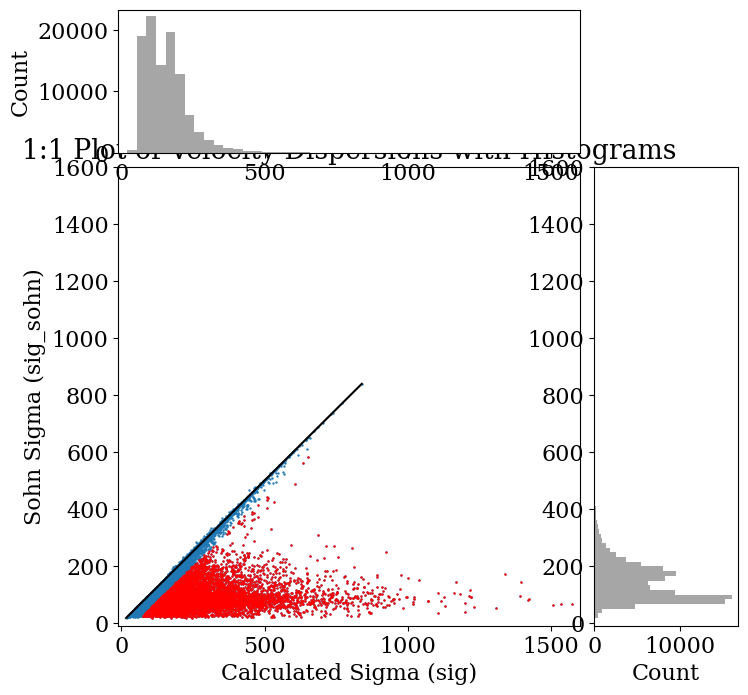

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

# Create figure with gridspec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4, hspace=0.1, wspace=0.1)

# Scatter plot (1:1 plot)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_scatter.plot(np.linspace(min(result_df['sig_sohn']), max(result_df['sig_sohn']), 100),
                np.linspace(min(result_df['sig_sohn']), max(result_df['sig_sohn']), 100), 
                color='k', label="1:1 Line")
ax_scatter.scatter(result_df['sig'], result_df['sig_sohn'], s=0.5)
plt.scatter(result_df[outliers]['sig'], result_df[outliers]['sig_sohn'], color='red', s=0.5, label='Outliers')

# Set equal aspect ratio
ax_scatter.set_xlim(-10, 1600)
ax_scatter.set_ylim(-10, 1600)

# Histograms for X-axis (top panel)
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histx.hist(result_df['sig'], bins=50, color='gray', alpha=0.7)
ax_histx.set_ylabel('Count')

# Histograms for Y-axis (right panel)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)
ax_histy.hist(result_df['sig_sohn'], bins=50, color='gray', alpha=0.7, orientation='horizontal')
ax_histy.set_xlabel('Count')

# Labels and Titles
ax_scatter.set_xlabel('Calculated Sigma (sig)')
ax_scatter.set_ylabel('Sohn Sigma (sig_sohn)')
ax_scatter.set_title('1:1 Plot of Velocity Dispersions with Histograms')

plt.show()


In [41]:
residuals = result_df['sig_sohn'] - result_df['sig']

# Calculate standard deviation (sigma) of residuals
sigma = np.std(residuals)

# Find the points that deviate more than 1 sigma
#outliers = np.abs(residuals) > sigma
outliers = np.abs(residuals) > 50

# Count the number of outliers
num_outliers = np.sum(outliers)
print(len(residuals))
print(num_outliers)
print(num_outliers / len(residuals))

104091
7726
0.0742235159619948
